In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import spacy
from helpers import *
import os
import codecs
from collections import Counter
import pandas as pd
import seaborn as sns
import json
import urllib.parse
from urllib.request import urlopen
from scipy.stats import pearsonr
from scipy.stats import linregress
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch

# RQ1: How much are groups and individuals described?

## Load data

Each file in `DATA_DIR` should be a separate `.txt` file, representing a separate document. In our case, each file is a textbook.

In [2]:
DATA_DIR = "data/coref_resolved_txts"

In [172]:
books = get_book_txts(DATA_DIR, splitlines=True)

Getting books...
America_A_Narrative_History_WWNorton_10th
America_Past_And_Present_Pearson_10th
Americas_History_Bedford_8th
Give_Me_Liberty_An_American_History_WWNorton_3rd
The_American_Pageant_Cengage_14th
The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th
Visions_of_America_A_History_of_the_United_States_Pearson_2nd
american_history_connecting_with_the_past
by_the_people
history_alive_united_states_thru_industrialism
hmh_the_americans_us_history_since_1877
mastering_the_teks
pearson_us_history
teks_us_history
us_history_early_colonial_period_through_reconstruction
Finished getting books.


In [173]:
books['America_A_Narrative_History_WWNorton_10th'][:2]

['History is filled with ironies. Luck and accidents—the unexpected and unplanned happenings of \xadlife—\u200b\xadoften shape events more than intentions. Long before Christopher Columbus lucked upon the Caribbean Sea and an unexpected continent in his effort to find a westward passage to the Indies (east Asia), the native peoples his mislabeled "Indians" had occupied and transformed the lands of the Western Hemisphere (also called the \xadAmericas—\u200b \xadNorth, Central, and South).',
 'Initially, everyone in what came to be called America came from somewhere else. By 1492, when Columbus began his voyage west from Spain across an uncharted ocean, there were millions of Native Americans living in the Western Hemisphere. The "New World" his found was new only to the Europeans who began exploring, conquering, and exploiting the region at the end of the fifteenth century. Over thousands of years, Native American peoples had developed highly sophisticated societies. Some were rooted in

In [98]:
# Median proportion of democratic votes in counties where book was purchased
with open('data/dem_per_book.json', 'r') as f:
    book2dem = json.load(f)

In [99]:
book2dem

{'by_the_people': 35.30929418268936,
 'american_history_connecting_with_the_past': 42.96916953105053,
 'teks_us_history': 26.177359161187137,
 'hmh_the_americans_us_history_since_1877': 24.373143196672608,
 'The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th': 45.46525138220405,
 'Give_Me_Liberty_An_American_History_WWNorton_3rd': 45.46525138220405,
 'The_American_Pageant_Cengage_14th': 37.182642762849724,
 'us_history_early_colonial_period_through_reconstruction': 24.092744704815804,
 'Americas_History_Bedford_8th': 41.62841051148274,
 'history_alive_united_states_thru_industrialism': 38.26930702307493,
 'Visions_of_America_A_History_of_the_United_States_Pearson_2nd': 23.50676864267128,
 'pearson_us_history': 21.83387065793427,
 'America_A_Narrative_History_WWNorton_10th': 23.115068427916007,
 'America_Past_And_Present_Pearson_10th': 44.776641592849984,
 'mastering_the_teks': 25.17798596240148}

##### For plotting

In [100]:
title_abbr = get_title_abbr()
title2shape = get_shapes(abbr=True) # abbreviated titles to shapes
title2color = get_colors(abbr=True) # abbreviated titles to colors

In [101]:
shape_mapper

{'America_A_Narrative_History_WWNorton_10th': 'o',
 'America_Past_And_Present_Pearson_10th': '8',
 'american_history_connecting_with_the_past': 'H',
 'Americas_History_Bedford_8th': 'p',
 'by_the_people': 'X',
 'Give_Me_Liberty_An_American_History_WWNorton_3rd': 's',
 'history_alive_united_states_thru_industrialism': '*',
 'hmh_the_americans_us_history_since_1877': '>',
 'mastering_the_teks': 'P',
 'pearson_us_history': 'v',
 'teks_us_history': '^',
 'The_American_Pageant_Cengage_14th': 'D',
 'The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th': 'd',
 'us_history_early_colonial_period_through_reconstruction': '<',
 'Visions_of_America_A_History_of_the_United_States_Pearson_2nd': 'h'}

## Run Dependency Parsing & Tagging

In [9]:
# Load Spacy model for English
nlp = spacy.load("en_core_web_sm")

Running the parser on the documents might take a while (depending on the size and number of documents you have, and the length of each line).

In [10]:
parsed_books = {}
for title, textbook_lines in books.items():
    print(title)
    parsed_books[title] = []
    for line in textbook_lines:
        parsed_books[title].append(nlp(line))

America_A_Narrative_History_WWNorton_10th
America_Past_And_Present_Pearson_10th
Americas_History_Bedford_8th
Give_Me_Liberty_An_American_History_WWNorton_3rd
The_American_Pageant_Cengage_14th
The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th
Visions_of_America_A_History_of_the_United_States_Pearson_2nd
american_history_connecting_with_the_past
by_the_people
history_alive_united_states_thru_industrialism
hmh_the_americans_us_history_since_1877
mastering_the_teks
pearson_us_history
teks_us_history
us_history_early_colonial_period_through_reconstruction


## Count mentions of different groups

In [102]:
PEOPLE_TERMS = "wordlists/people_terms.csv"

In [103]:
people_terms_df = pd.read_csv(PEOPLE_TERMS, header=None, names=['word', 'demographic', 'category'])
people_terms_df

,word,demographic,category
0,black,black,race/ethnicity
1,african,black,race/ethnicity
2,slave,black,race/ethnicity
3,negro,black,race/ethnicity
4,african-american,black,race/ethnicity
...,...,...,...
2110,organizations,other,unmarked
2111,unions,other,unmarked
2112,locals,other,unmarked
2113,villages,other,unmarked


In [104]:
possible_marks, not_marks = split_terms_into_sets(PEOPLE_TERMS)

In [105]:
possible_marks

{'african',
 'african-american',
 'african-americans',
 'africanamerican',
 'africanamericans',
 'africans',
 'algonquian',
 'algonquians',
 'amish',
 'anasazi',
 'anasazis',
 'anglo',
 'anglo-american',
 'anglo-americans',
 'anglo-saxon',
 'anglo-saxons',
 'anglo-texan',
 'anglo-texans',
 'anglos',
 'apache',
 'apaches',
 'arapaho',
 'arapahos',
 'asian',
 'asian-american',
 'asian-americans',
 'asians',
 'aunt',
 'aunts',
 'australian',
 'australians',
 'austrian',
 'austrians',
 'aztec',
 'aztecs',
 'barbadian',
 'black',
 'blacks',
 'bolshevik',
 'bolsheviks',
 'boy',
 'boys',
 'bracero',
 'braceros',
 'brethren',
 'bride',
 'brides',
 'bridesmaid',
 'bridesmaids',
 'british',
 'briton',
 'britons',
 'brother',
 'brothers',
 'businessman',
 'businessmen',
 'caribbean',
 'caribbeans',
 'cattleman',
 'cattlemen',
 'chairman',
 'chairmen',
 'cherokee',
 'cherokees',
 'cheyenne',
 'cheyennes',
 'chicano',
 'chicanos',
 'chickasaw',
 'chickasaws',
 'choctaw',
 'choctaws',
 'clergyman',


In [106]:
not_marks

{'dignitaries',
 'nomad',
 'teams',
 'directors',
 'orator',
 'christians',
 'committees',
 'colonels',
 'vaquero',
 'dealer',
 'whigs',
 'conquistadors',
 'californian',
 'dockworker',
 'heterosexual',
 'lieutenant',
 'patrons',
 'strategist',
 'boycotters',
 'operative',
 'co-founder',
 'challenger',
 'carolinian',
 'tutors',
 'attacker',
 'ruler',
 'founder',
 'idealist',
 'losers ',
 'americans',
 'national',
 'greenbacker',
 'gay',
 'individualist',
 'thieves',
 'planners',
 'cults',
 'prospectors',
 'builder',
 'speculators',
 'stranger',
 'worshiper',
 'audience',
 'translators',
 'subcommittee',
 'survivors',
 'user',
 'nationalist',
 'defenders',
 'researcher',
 'contacts',
 'orphans',
 'mississippians',
 'agents',
 'movement',
 'jockey',
 'dissenters',
 'public',
 'riders',
 'civilians',
 'masters',
 'cooks',
 'gunners',
 'imperialists',
 'revivalist',
 'partner',
 'cleaners',
 'anti-masons',
 'spouses',
 'ruffians',
 'outcasts',
 'spy',
 'aides',
 'activist',
 'administrator

In [107]:
word2dem = get_word_to_category(PEOPLE_TERMS)

In [108]:
word2dem

{'black': 'black',
 'african': 'black',
 'slave': 'black',
 'negro': 'black',
 'african-american': 'black',
 'freedman': 'black',
 'freedwoman': 'black',
 'freeman': 'black',
 'mulatto': 'black',
 'nigger': 'black',
 'creole': 'black',
 'africanamerican': 'black',
 'freedperson': 'black',
 'ex-slave': 'black',
 'fugitive': 'black',
 'runaway': 'black',
 'enslaved': 'black',
 'blacks': 'black',
 'africans': 'black',
 'slaves': 'black',
 'negroes': 'black',
 'african-americans': 'black',
 'freedmen': 'black',
 'freedwomen': 'black',
 'freemen': 'black',
 'mulattoes': 'black',
 'niggers': 'black',
 'creoles': 'black',
 'africanamericans': 'black',
 'freedpeople': 'black',
 'ex-slaves': 'black',
 'fugitives': 'black',
 'runaways': 'black',
 'hispanic': 'hispanic/latinx',
 'mexican': 'hispanic/latinx',
 'latino': 'hispanic/latinx',
 'latina': 'hispanic/latinx',
 'mexicano': 'hispanic/latinx',
 'mexican-american': 'hispanic/latinx',
 'chicano': 'hispanic/latinx',
 'panamanian': 'hispanic/lat

In [109]:
count_df = []
for title, parsed_lines in parsed_books.items():
    print(title)
    dem_dict = Counter() # demographic : count
    for doc in parsed_lines:
        prev_word = None
        for token in doc: 
            word = token.text.lower()
            # only look at nouns
            if token.pos_ != 'PROPN' and \
                token.pos_ != 'NOUN' and token.pos_ != 'PRON': continue
            if word in possible_marks:
                dem_dict[word2dem[word]] += 1
                if prev_word in possible_marks:
                    # count previous word as well
                    # e.g. "black women"
                    dem_dict[word2dem[prev_word]] += 1
            elif word in not_marks:
                if prev_word not in possible_marks: 
                    dem_dict[word2dem[word]] += 1
                else: 
                    # count previous word but not unmarked word
                    dem_dict[word2dem[prev_word]] += 1
            prev_word = word
    for demographic in dem_dict: 
        count_df.append({
            "title": title,
            "demographic": demographic,
            "count": dem_dict[demographic]
        })

America_A_Narrative_History_WWNorton_10th
America_Past_And_Present_Pearson_10th
Americas_History_Bedford_8th
Give_Me_Liberty_An_American_History_WWNorton_3rd
The_American_Pageant_Cengage_14th
The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th
Visions_of_America_A_History_of_the_United_States_Pearson_2nd
american_history_connecting_with_the_past
by_the_people
history_alive_united_states_thru_industrialism
hmh_the_americans_us_history_since_1877
mastering_the_teks
pearson_us_history
teks_us_history
us_history_early_colonial_period_through_reconstruction


In [110]:
count_df = pd.DataFrame(count_df)
count_df

,title,demographic,count
0,America_A_Narrative_History_WWNorton_10th,other minority,2478
1,America_A_Narrative_History_WWNorton_10th,other,32787
2,America_A_Narrative_History_WWNorton_10th,white,2523
3,America_A_Narrative_History_WWNorton_10th,black,2915
4,America_A_Narrative_History_WWNorton_10th,men,4483
...,...,...,...
100,us_history_early_colonial_period_through_recon...,other minority,1181
101,us_history_early_colonial_period_through_recon...,men,1403
102,us_history_early_colonial_period_through_recon...,women,798
103,us_history_early_colonial_period_through_recon...,black,1369


### Correlate counts with political leanings of people who purchased the books

You can use any other correlate, which makes most sense in your use case.

In [111]:
book2total = count_df.groupby("title").sum().to_dict()["count"]
book2total

{'America_A_Narrative_History_WWNorton_10th': 48045,
 'America_Past_And_Present_Pearson_10th': 49959,
 'Americas_History_Bedford_8th': 51249,
 'Give_Me_Liberty_An_American_History_WWNorton_3rd': 42742,
 'The_American_Pageant_Cengage_14th': 42540,
 'The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th': 32054,
 'Visions_of_America_A_History_of_the_United_States_Pearson_2nd': 41412,
 'american_history_connecting_with_the_past': 46965,
 'by_the_people': 47262,
 'history_alive_united_states_thru_industrialism': 20705,
 'hmh_the_americans_us_history_since_1877': 33442,
 'mastering_the_teks': 8503,
 'pearson_us_history': 42549,
 'teks_us_history': 38703,
 'us_history_early_colonial_period_through_reconstruction': 21101}

In [112]:
count_dict = count_df.set_index(["title", "demographic"])["count"].to_dict()

In [113]:
count_plot_df = []
for title, book in count_df.groupby("title"):
    count_plot_df.append({
        "book": title_abbr[title],
        "dem_prop": book2dem[title],
        "Black People": count_dict[(title ,"black")] / book2total[title] * 100,
        "Women": count_dict[(title ,"women")] / book2total[title] * 100,
    })
count_plot_df = pd.DataFrame(count_plot_df)

In [114]:
count_plot_df

,book,dem_prop,Black People,Women
0,"Am. Narr. Hist., W.W.N.",23.115068,6.067229,5.471953
1,"Am. Past & Present, Pearson",44.776642,6.311175,6.193078
2,"Am. Hist., Bedford",41.628411,6.361100,7.260629
3,"Give Me Liberty, W.W.N.",45.465251,8.062327,6.012821
4,"The Am. Pageant, Cengage",37.182643,5.298543,5.021157
5,"The Unfinished Nation, M.H.",45.465251,5.163162,5.777750
6,"Visions of Am., Pearson",23.506769,6.396697,5.638462
7,"Am. Hist. Conn. w/ Past, M.H.",42.969170,4.841904,5.921431
8,"By The People, Pearson",35.309294,6.136008,5.281198
9,"Hist. Alive!, TCI",38.269307,7.162521,5.790872


In [119]:
def plot_on_axis(df, ax, title, x="dem_prop", show_legend=False, fontsize=12, show_ylabel=True):
    p = sns.scatterplot(x, # Horizontal axis
       title, # Vertical axis
       data=df, # Data source
       hue='book',
       style='book',
       markers=title2shape,
       palette=title2color,
       s=100, ax=ax, legend=show_legend)
    
    slope, intercept, r_value, p_value, std_err = linregress(df[x], df[title])
    ax.plot(df[x], intercept + slope*df[x], 'grey', label='_nolegend_')
    print(p_value)
    ax.text(x=38, y=.8,s="$\it{r}$ = %.2f\n$\it{p}$ < %s" % (r_value, str(p_value+0.01)[:4]))
    ax.set_title(title, fontsize=fontsize+4)
    if show_ylabel:
        ax.set_ylabel('% of Total People Terms', fontsize=fontsize)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Median % of Democrats Across Counties\nWhere Book is Bought', fontsize=fontsize)
    ax.set_ylim(0, 8.5)
    sns.despine()

0.15907037855198802
0.003923080007206108


<Figure size 432x288 with 0 Axes>

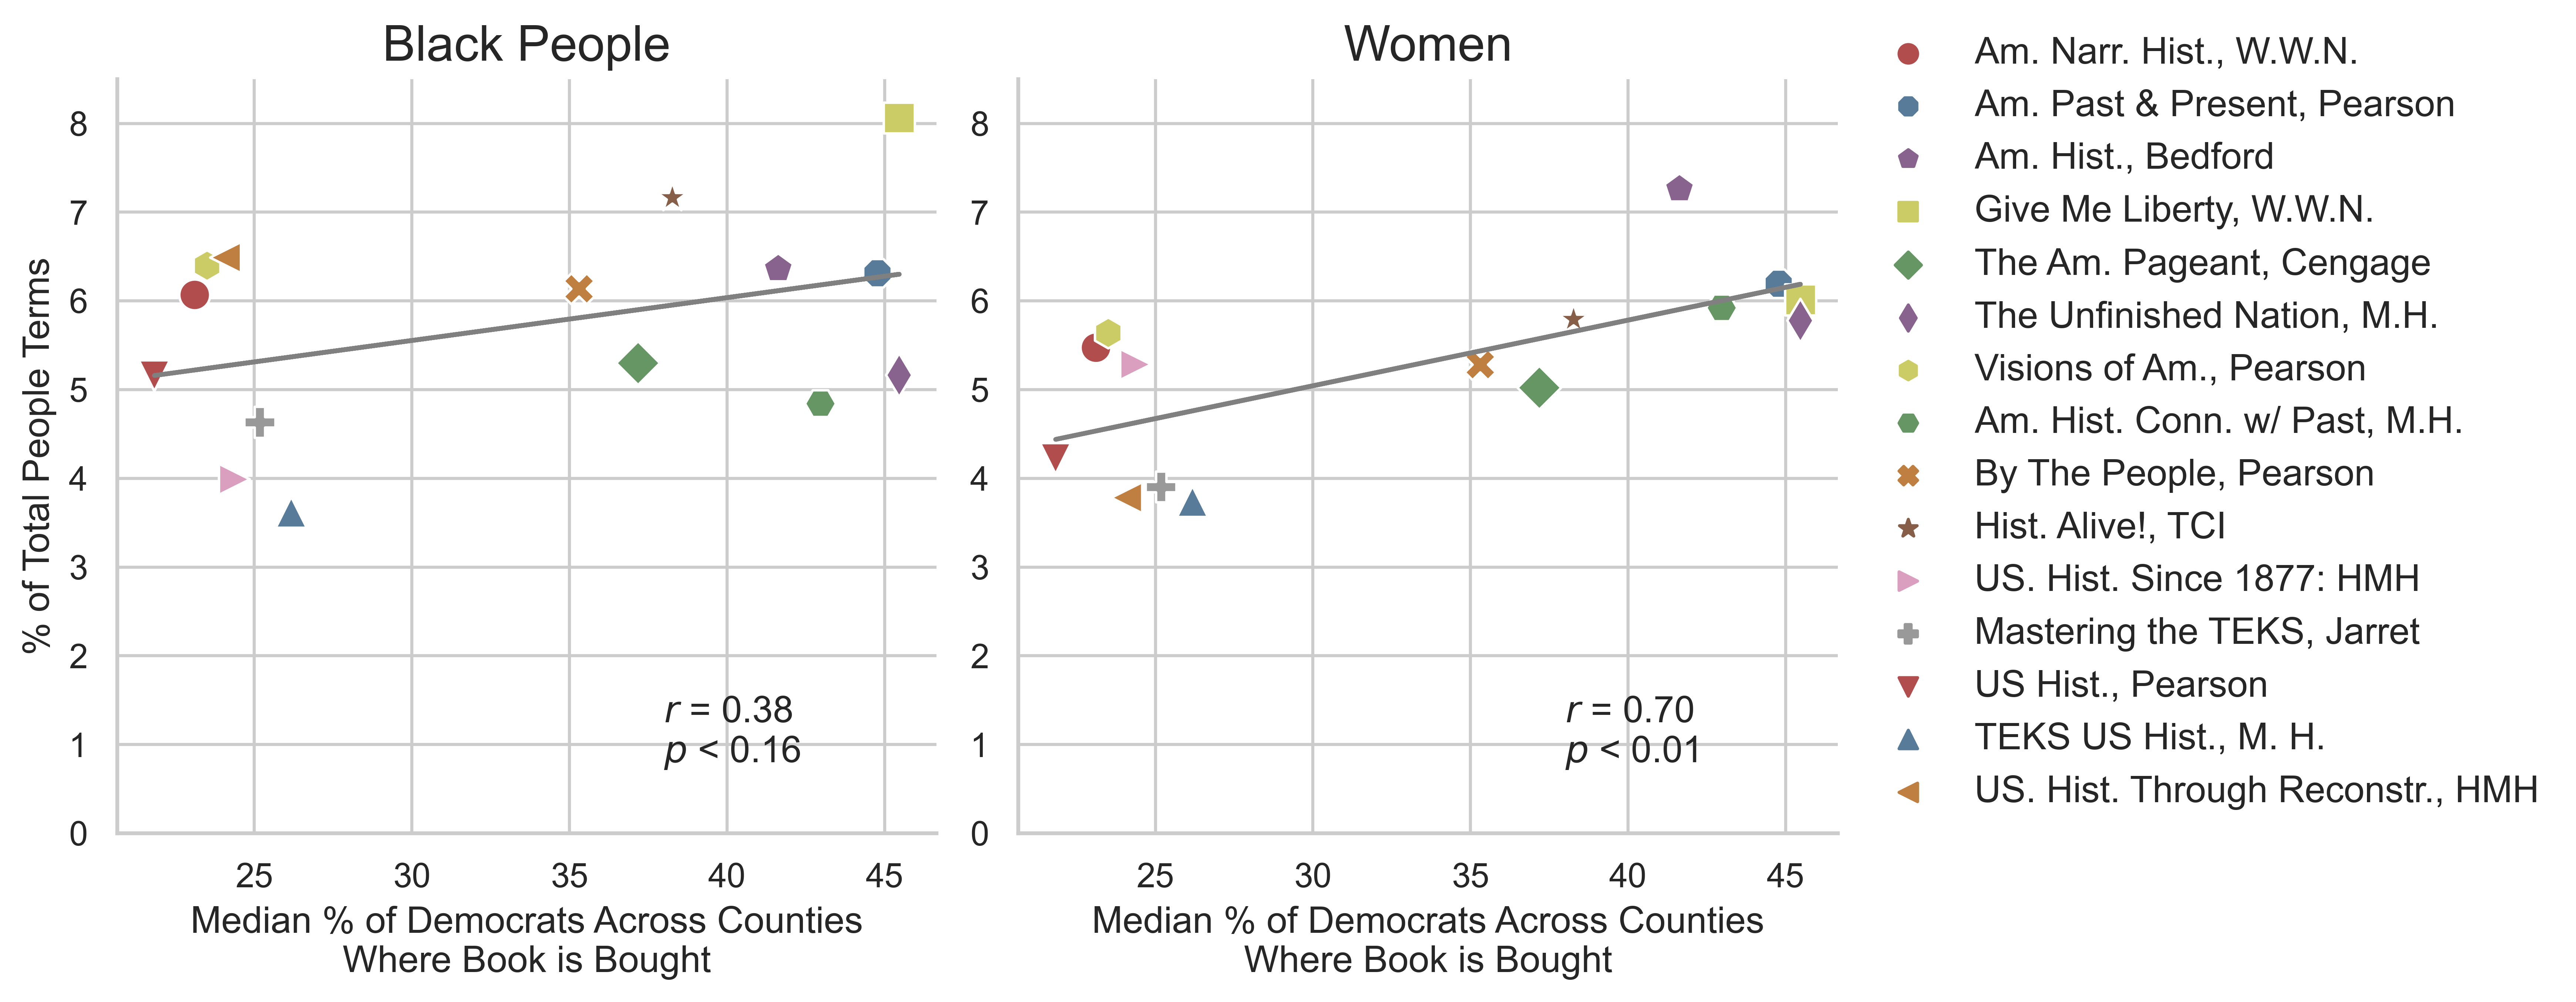

In [120]:
sns.set(style='whitegrid')
sns.despine()
fontsize=12
fig = plt.figure(figsize=(10, 4.5), dpi=600)
gs = gridspec.GridSpec(nrows=1, ncols=2, figure=fig, wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
width = 0.35
plot_on_axis(count_plot_df, ax1, "Black People", fontsize=fontsize, show_ylabel=True)
ax2 = fig.add_subplot(gs[0, 1:3])
plot_on_axis(count_plot_df, ax2, "Women", show_legend="full", fontsize=fontsize, show_ylabel=False)
l = plt.legend(bbox_to_anchor=(1,1.1), loc="upper left", frameon=False, fontsize=fontsize)
#l.texts[0].set_text('')

Note: here we are using a different parser (Spacy as opposed to Dozat et al. (2019), which leads to a slightly different result than what we have in the paper). Namely, in the paper, the trend of Black People is more significant than that for Women, but here we find the opposite. The trend is still positive for both results.

## Get counts for named entities

#### Step 0: Run Named Entity Recognition (NER) --> We already did this by running SpaCy on the data.

#### Step 1: Replace aliases with standardized wikidata names.

In [150]:
def clean_entity(entity):
    entity = entity.replace("\"", "").replace("—", "").replace("\\","")
    if entity.endswith("'s"):  # Remove possessives
        entity = entity[:-2]
    entity = entity.split(",")[0] # Only consider what's before commas
    entity = entity.strip()
    return entity

In [123]:
def get_official_name(entity):
    """Get possible official name(s) for entity based on Wikidata."""
    url_prefix = "https://query.wikidata.org/sparql?format=json&query="
    query = urllib.parse.quote("SELECT ?item ?itemLabel WHERE {" + \
    "?item wdt:P31 wd:Q5." + \
    "?item ?label \"" + entity + "\"@en ." + \
    "SERVICE wikibase:label { bd:serviceParam wikibase:language \"en\". }" + \
    "}", safe='')
    url = url_prefix + query
    res = json.loads(urlopen(url).read())
    cands = []
    if len(res['results']['bindings']) > 0:
        for i in range(len(res['results']['bindings'])): 
            wikiID = res['results']['bindings'][i]['item']['value'].split('/')[-1]
            name = res['results']['bindings'][i]['itemLabel']['value'].split('/')[-1]
            cands.append((name, wikiID)) 
    return cands

In [152]:
# This script takes a while to run.
full2wikiname = {}        
famous_counter = Counter()
print("Getting wikidata aliases and most common people...")
for title, parsed_lines in parsed_books.items():
    print(title)
    for doc in parsed_lines: 
        for ent in doc.ents: 
            if (ent.label_ == 'PERSON' and not ent.text[0].isdigit()):
                curr_entity = clean_entity(ent.text)
                if curr_entity in full2wikiname: 
                    curr_entity = full2wikiname[curr_entity]
                elif curr_entity not in full2wikiname and len(curr_entity.split()) > 1: 
                    cands = get_official_name(curr_entity)
                    if len(cands) == 1: 
                        full2wikiname[curr_entity] = cands[0][0]
                    else: 
                        # do not match ambiguous terms
                        full2wikiname[curr_entity] = curr_entity
                    curr_entity = full2wikiname[curr_entity]
                else: # ent.text not in full2wikiname and ent.text is single token
                    full2wikiname[curr_entity] = curr_entity
                famous_counter[curr_entity] += 1

Getting wikidata aliases and most common people...
America_A_Narrative_History_WWNorton_10th
America_Past_And_Present_Pearson_10th
Americas_History_Bedford_8th
Give_Me_Liberty_An_American_History_WWNorton_3rd
The_American_Pageant_Cengage_14th
The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th
Visions_of_America_A_History_of_the_United_States_Pearson_2nd
american_history_connecting_with_the_past
by_the_people
history_alive_united_states_thru_industrialism
hmh_the_americans_us_history_since_1877
mastering_the_teks
pearson_us_history
teks_us_history
us_history_early_colonial_period_through_reconstruction


#### Step 2: Find top 100 most common famous people. 
This means from here on out we only focus on them and we're allowed to 
ignore noisy entities, e.g. "Response Roosevelt." 

In [153]:
famous_people = set()
for tup in famous_counter.most_common(100):
    famous_people.add(tup[0])

In [154]:
# Save for later
with open('./results/full2wikiname.json', 'w') as outfile: 
            json.dump(full2wikiname, outfile)

# save famous people for getting descriptors later
with open('./wordlists/famous_people.txt', 'w') as outfile: 
    for person in famous_people: 
        outfile.write(person + '\n')

In [155]:
# Load from file if already saved
with open('./results/full2wikiname.json', 'r') as infile: 
            full2wikiname = json.load(infile)

famous_people = set()
# save famous people for getting descriptors later
with open('./wordlists/famous_people.txt', 'r') as infile: 
    for line in infile: 
        famous_people.add(line.strip())

#### Step 3: Matching last names to full names.

As we move through the text and  find named entities, we keep a running dictionary of last name to full names. 
So, if we see "Theodore Roosevelt" we have `{Roosevelt: Theodore Roosevelt}`, and  so if we see just "Roosevelt" later, we look it up in the dictionary.  This dictionary is updated so each last name only has one full name. 
So, if we move later on in history, eventually we will hit someone named  "Franklin Roosevelt" and the value for the key "Roosevelt" will become `{ Roosevelt: Franklin Roosevelt }`. This means a last name is paired with the most recent full name related to it.  

In [156]:
NAMED_ENTITY_DIR = 'results/named_people'
os.makedirs(NAMED_ENTITY_DIR, exist_ok=True)

In [157]:
for title, parsed_lines in parsed_books.items():
    print(title)
    entity_counter = Counter() # this time matching last names to common full names
    name_map = {} # last : full
    for doc in parsed_lines: 
        replacements = {} # start : (entity, end)
        for ent in doc.ents: 
            if (ent.label_ == 'PERSON' and not ent.text[0].isdigit()): 
                curr_entity = clean_entity(ent.text)
                if curr_entity in full2wikiname and curr_entity != full2wikiname[curr_entity]: 
                    # replace with wikiname
                    print("REPLACE", curr_entity, full2wikiname[curr_entity])
                    curr_entity = full2wikiname[curr_entity]
                if len(curr_entity.split()) == 1: 
                    if curr_entity in name_map: 
                        # replace last name with latest full name
                        curr_entity = name_map[curr_entity]
                elif curr_entity in famous_people: 
                    # name map should only contain famous people
                    last = curr_entity.split()[-1]
                    name_map[last] = curr_entity
                entity_counter[curr_entity] += 1
                if curr_entity != ent.text: 
                    replacements[ent.start_char] = (curr_entity, ent.end_char)
        new_line = ''
        curr_end = -1
        for idx, char in enumerate(line): 
            if idx in replacements: 
                curr_end = replacements[idx][1]
                new_line += replacements[idx][0] 
            elif idx >= curr_end: 
                new_line += char
    print('----------------------')
    with open(os.path.join(NAMED_ENTITY_DIR, title), 'w') as outfile: 
        for tup in entity_counter.items():
            if tup[1] < 5: # only save names that occur at least 5 times
                continue
            outfile.write(tup[0] + ',' + str(tup[1]) + '\n')
            print(tup[0] + ',' + str(tup[1]))
    print('----------------------')

America_A_Narrative_History_WWNorton_10th
REPLACE Queen Isabella Isabella I of Castile
REPLACE Queen Isabella Isabella I of Castile
REPLACE Charles V Charles V of France
REPLACE Mary I Mary I of Hungary
REPLACE Montezuma II Moctezuma II
REPLACE Montezuma II Moctezuma II
REPLACE Bernal Diaz del Castillo Bernal Díaz del Castillo
REPLACE St. Augustine Augustine of Hippo
REPLACE Pope Paul III Paul III
REPLACE Montezuma II Moctezuma II
REPLACE King Philip Metacomet
REPLACE King Philip Metacomet
REPLACE St. Augustine Augustine of Hippo
REPLACE James VI James VI and I
REPLACE John Weesop Jan Weesop
REPLACE King Philip Metacomet
REPLACE King Philip Metacomet
REPLACE Prudence Punderson Prudence Punderson Rossiter
REPLACE John Hughson John Hewson
REPLACE John Hughson John Hewson
REPLACE Louis XIV Louis XIV of France
REPLACE Louis XIV Louis XIV of France
REPLACE Louis XIV Louis XIV of France
REPLACE Louis XIV Louis XIV of France
REPLACE Louis XIV Louis XIV of France
REPLACE Louis XIV Louis XIV of

REPLACE Mad Mike Mike Calvert
REPLACE James O. Eastland James Oliver Eastland
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Josef Stalin Joseph Stalin
REPLACE Allen Dulles Allen Welsh Dulles
REPLACE Jacobo Arbenz Guzman Jacobo Árbenz
REPLACE Dwight Eisenhower Dwight D. Eisenhower
REPLACE Dwight Eisenhower Dwight D. Eisenhower
REPLACE Dwight Eisenhower Dwight D. Eisenhower
REPLACE Dwight Eisenhower Dwight D. Eisenhower
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Dwight Eisenhower Dwight D. Eisenhower
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Dr. King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Har

REPLACE Thomas A. Edison Thomas Alva Edison
REPLACE Thomas A. Edison Thomas Alva Edison
REPLACE Thomas A. Edison Thomas Alva Edison
REPLACE Gustavus F. Swift Gustavus Franklin Swift
REPLACE Emile Zola Émile Zola
REPLACE R. H. Macy Rowland Hussey Macy
REPLACE James B. Duke James Buchanan Duke
REPLACE James B. Duke James Buchanan Duke
REPLACE R. H. Macy Rowland Hussey Macy
REPLACE Alvah C. Roebuck Alvah Curtis Roebuck
REPLACE Herbert G. Gutman Herbert Gutman
REPLACE Thomas A. Edison Thomas Alva Edison
REPLACE Thomas A. Edison Thomas Alva Edison
REPLACE Mother Jones Mary Harris Jones
REPLACE Louis H. Sullivan Louis Sullivan
REPLACE William M. Tweed William Magear Tweed
REPLACE Frances E. Willard Frances Willard
REPLACE W. E. B. Du Bois W.E.B. Du Bois
REPLACE W. E. B. Du Bois W.E.B. Du Bois
REPLACE William T. Stead W. T. Stead
REPLACE William T. Stead W. T. Stead
REPLACE William T. Stead W. T. Stead
REPLACE Thomas B. Reed Thomas Brackett Reed
REPLACE Jeremiah Simpson Jerry Simpson
REPLACE 

REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Walt Rostow Walt Whitman Rostow
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Milton Friedman Milton Friedman Correa
REPLACE George S. McGovern George McGovern
REPLACE H. R. Haldeman Harry Robbins Haldeman
REPLACE Paul Michael Szep Paul Szep
REPLACE Gerald R. Ford Gerald Ford
REPLACE Gerald R. Ford Gerald Ford
REPLACE Gerald R. Ford Gerald Ford
REPLACE Joseph Califano Joseph A. Califano, Jr.
REPLACE Anastasio Somoza Anastasio Somoza Debayle
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Tammy Bakker Tammy Faye Messner
REPLACE Tammy Bakker Tammy Faye Messner
REPLACE Tammy Bakker Tammy Faye Messner
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Lech Walesa Lech Wałęsa
REPLACE Lech Walesa Lech Wa

REPLACE I. N. Phelps Stokes Isaac Newton Phelps Stokes
REPLACE John French Sloan John Sloan
REPLACE Dwight L. Moody Dwight Lyman Moody
REPLACE Frank Sprague Frank J. Sprague
REPLACE Charles F. Brush Charles Francis Brush
REPLACE Grizzly Bear Justin Frazier
REPLACE Boss Tweed William Magear Tweed
REPLACE Stephen S. Wise Stephen Samuel Wise
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Charles Guiteau Charles J. Guiteau
REPLACE Ben Tillman Benjamin Ryan Tillman, Jr.
REPLACE Ben Tillman Benjamin Ryan Tillman, Jr.
REPLACE Ben Tillman Benjamin Ryan Tillman, Jr.
REPLACE Ben Tillman Benjamin Ryan Tillman, Jr.
REPLACE Howell Jackson Howell Edmunds Jackson
REPLACE C. M. Bell Charles Milton Bell
REPLACE Oliver Wendell Holmes Jr. Oliver Wendell Holmes
REPLACE Oliver Wendell Holmes Jr. Oliver Wendell Holmes
REPLACE Jack the Giant Killer Jack Dillon
REPLACE Robert La Follette Robert M. La Follette
REPLACE Robert La Follette Robert M. La Follette
REPLACE Robert La Follette Robert M

REPLACE King Philip Metacomet
REPLACE King Philip Metacomet
REPLACE King Philip Metacomet
REPLACE King Philip Metacomet
REPLACE King Philip Metacomet
REPLACE Gustavus Vassa Olaudah Equiano
REPLACE St. Augustine Augustine of Hippo
REPLACE King George III George III of Great Britain
REPLACE King George III George III of Great Britain
REPLACE King George III George III of Great Britain
REPLACE King George III George III of Great Britain
REPLACE King George III George III of Great Britain
REPLACE Thomas Pritchard Rossiter Thomas Prichard Rossiter
REPLACE Tadeusz Kosciuszko Tadeusz Kościuszko
REPLACE Pierre-Charles L'Enfant Pierre Charles L'Enfant
REPLACE Pierre-Charles L'Enfant Pierre Charles L'Enfant
REPLACE Toussaint L'Ouverture Toussaint Louverture
REPLACE Toussaint L'Ouverture Toussaint Louverture
REPLACE Henry C. Carey Henry Charles Carey
REPLACE Samuel F. B. Morse Samuel Morse
REPLACE James Tallmadge James Tallmadge, Jr.
REPLACE James H. Hammond James Henry Hammond
REPLACE Robert Y. 

REPLACE Denis Kearney Dennis Kearney
REPLACE Thomas B. Reed Thomas Brackett Reed
REPLACE Thomas B. Reed Thomas Brackett Reed
REPLACE Thomas Edward Watson Thomas E. Watson
REPLACE Thomas Edward Watson Thomas E. Watson
REPLACE Thomas Edward Watson Thomas E. Watson
REPLACE Thomas Edward Watson Thomas E. Watson
REPLACE Thomas Edward Watson Thomas E. Watson
REPLACE Thomas Edward Watson Thomas E. Watson
REPLACE Thomas Edward Watson Thomas E. Watson
REPLACE Thomas Edward Watson Thomas E. Watson
REPLACE John D. Hicks John Donald Hicks
REPLACE Henry Poor Henry Varnum Poor
REPLACE Collis P. Huntington Collis Potter Huntington
REPLACE James Baird Weaver James B. Weaver
REPLACE Gustavus F. Swift Gustavus Franklin Swift
REPLACE Gustavus F. Swift Gustavus Franklin Swift
REPLACE Thomas Malthus Thomas Robert Malthus
REPLACE Lewis W. Hine Lewis Hine
REPLACE Lewis W. Hine Lewis Hine
REPLACE Lewis W. Hine Lewis Hine
REPLACE Lewis W. Hine Lewis Hine
REPLACE Lewis W. Hine Lewis Hine
REPLACE Lewis W. Hine L

REPLACE Hillary Rodham Clinton Hillary Clinton
REPLACE Joseph Biden Joe Biden
REPLACE Joseph Biden Joe Biden
REPLACE Jack Rakove Jack N. Rakove
REPLACE L. Douglas Wilder Douglas Wilder
REPLACE N. Scott Nicholas Scott
REPLACE N. Scott Nicholas Scott
REPLACE E. Annie Proulx Annie Proulx
REPLACE E. Annie Proulx Annie Proulx
REPLACE E. Annie Proulx Annie Proulx
REPLACE George Sanchez George J. Sánchez
----------------------
Thomas Jefferson,310
Isabella,5
Juan Ponce de León,6
John Cabot,7
Interactive Map,49
Battle,24
Henry VIII,8
Elizabeth,7
Francis Drake,8
Shakespeare,6
De La Warr,6
George Percy,5
Pocahontas,5
Smith,17
Woodrow Wilson,131
Benjamin Franklin,66
James,16
Baltimore,11
Jesus,5
Carolina,15
Charles,8
Charles II,12
William Penn,7
Rice,5
Edmund S. Morgan,5
John Calvin,5
Plymouth,9
John Winthrop,9
Anne Hutchinson,17
Williams,18
Roger Williams,10
Metacomet,5
King William,6
Edmund Andros,7
Ralph Waldo Emerson,18
Richard White,5
George Washington,71
Bacon,8
Nathaniel Hawthorne,8
Willia

REPLACE George S. McGovern George McGovern
REPLACE James W. McCord James W. McCord, Jr.
REPLACE James W. McCord James W. McCord, Jr.
REPLACE Gerald R. Ford Gerald Ford
REPLACE Gerald R. Ford Gerald Ford
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Robert Dole Bob Dole
REPLACE Hillary Rodham Clinton Hillary Clinton
REPLACE Robert Dole Bob Dole
REPLACE Robert Dole Bob Dole
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Kenneth Starr Ken Starr
REPLACE Hillary Rodham Clinton Hillary Clinton
REPLACE Hillary Rodham Clinton Hillary Clinton
REPLACE Hillary Rodham Clinton Hillary Clinton
----------------------
Christopher Columbus,19
Elizabeth,5
James,21
Abraham Lincoln,63
© Granger,21
John Locke,8
Thomas Paine,6
Martin Luther,5
Mary,8
Walter Raleigh,7
John Smith,9
John Rolfe,8
Getty Images,14
Pocahontas,8
George,5
Baltimore,9
Resentment Bacon,5
Williams,8
Cotton Mather,5
Devil,5
Hutchinson,10
Mohawk,6
Charles,8
Charles II,16
James II,14
Charles Town,5
George Fox,5
Qu

REPLACE Rip Van Winkle Walter Van Winkle
REPLACE William Tweed William Magear Tweed
REPLACE Jacob A. Riis Jacob Riis
REPLACE Jacob A. Riis Jacob Riis
REPLACE William K. Vanderbilt William Kissam Vanderbilt I
REPLACE Alva Vanderbilt Alva Belmont
REPLACE William K. Vanderbilt William Kissam Vanderbilt I
REPLACE Louis XV Louis XV of France
REPLACE William K. Vanderbilt William Kissam Vanderbilt I
REPLACE Ignatius Donnelly Ignatius L. Donnelly
REPLACE Eugene Debs Eugene V. Debs
REPLACE Teddy Roosevelt Theodore Roosevelt
REPLACE E. H. Harriman Edward Henry Harriman
REPLACE E. H. Harriman Edward Henry Harriman
REPLACE Ida B. Wells-Barnett Ida B. Wells
REPLACE Ida B. Wells-Barnett Ida B. Wells
REPLACE Ida B. Wells-Barnett Ida B. Wells
REPLACE Ida B. Wells-Barnett Ida B. Wells
REPLACE Ida B. Wells-Barnett Ida B. Wells
REPLACE W. E. B. Du Bois W.E.B. Du Bois
REPLACE W. E. B. Du Bois W.E.B. Du Bois
REPLACE Teddy Roosevelt Theodore Roosevelt
REPLACE Evangelina Cisneros Evangelina Cosio y Cisneros

REPLACE King Philip Metacomet
REPLACE King Philip Metacomet
REPLACE King Philip Metacomet
REPLACE King Philip Metacomet
REPLACE King Philip Metacomet
REPLACE Louis XIV Louis XIV of France
REPLACE Egbert van Heemskerck the Elder Egbert van Heemskerk
REPLACE Egbert van Heemskerck the Elder Egbert van Heemskerk
REPLACE Egbert van Heemskerck the Elder Egbert van Heemskerk
REPLACE Louis XIV Louis XIV of France
REPLACE St. Augustine Augustine of Hippo
REPLACE King Philip Metacomet
REPLACE King Philip Metacomet
REPLACE Winthrop D. Jordan Winthrop Jordan
REPLACE Winthrop D. Jordan Winthrop Jordan
REPLACE Louis XIV Louis XIV of France
REPLACE King George III George III of Great Britain
REPLACE King George III George III of Great Britain
REPLACE Louis XIV Louis XIV of France
REPLACE Pierre Gaultier de Varennes Pierre Gaultier de Varennes, sieur de La Vérendrye
REPLACE Louis XIV Louis XIV of France
REPLACE Saint John John of Alexandria
REPLACE Frederick the Great Frederick II of Prussia
REPLACE K

REPLACE Bernard Montgomery Bernard Law Montgomery, 1st Viscount Montgomery of Alamein
REPLACE Alfred Eisenstadt Alfred Eisenstaedt
REPLACE Alfred Eisenstadt Alfred Eisenstaedt
REPLACE Pearl Harbor Pearl E. Gates
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Bernard Montgomery Bernard Law Montgomery, 1st Viscount Montgomery of Alamein
REPLACE Chester Nimitz Chester W. Nimitz
REPLACE Joseph W. Stilwell Joseph Stilwell
REPLACE Joseph W. Stilwell Joseph Stilwell
REPLACE Joseph W. Stilwell Joseph Stilwell
REPLACE Emperor Hirohito Hirohito
REPLACE Emperor Hirohito Hirohito
REPLACE Emperor Hirohito Hirohito
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Emperor Hirohito Hirohito
REPLACE Alonzo L. Hamby Alonzo Hamby
REPLACE Philip Randolph A. Philip Randolph
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Harry Truman Harry S. Truman
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE George

REPLACE Rip Van Winkle Walter Van Winkle
REPLACE Catherine Beecher Catharine Beecher
REPLACE Catherine Beecher Catharine Beecher
REPLACE Catherine Beecher Catharine Beecher
REPLACE Junipero Serra Junípero Serra
REPLACE Eulalia Perez Eulalia Pérez de Guillén Mariné
REPLACE Eulalia Perez Eulalia Pérez de Guillén Mariné
REPLACE John C. Fremont John C. Frémont
REPLACE John C. Fremont John C. Frémont
REPLACE John C. Fremont John C. Frémont
REPLACE John C. Fremont John C. Frémont
REPLACE John C. Fremont John C. Frémont
REPLACE John C. Fremont John C. Frémont
REPLACE John C. Fremont John C. Frémont
REPLACE Henry J. Warre Henry Warre
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Mohandas Gandhi Mahatma Gandhi
REPLACE Hernan Cortes Hernán Cortés
REPLACE Stephen Watts Kearny Stephen W. Kearny
REPLACE Stephen Watts Kearny Stephen W. Kearny
REPLACE Stephen Watts Kearny Stephen W. Kearny
REPLACE Stephen Watts Kearny Stephen W. Kearny
REPLACE Andres Pico Andrés Pico
REPLACE Andres Pico A

REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Mohandas Gandhi Mahatma Gandhi
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Dwight Eisenhower Dwight D. Eisenhower
REPLACE Martin

REPLACE P. M. Hans Widmer
REPLACE P. M. Hans Widmer
REPLACE W. E. B. Du Bois W.E.B. Du Bois
REPLACE Frederick Douglas Frederick Sylvester North Douglas
REPLACE James Tallmadge James Tallmadge, Jr.
REPLACE Simon Legree John Patric
REPLACE Simon Legree John Patric
REPLACE Roger Taney Roger B. Taney
REPLACE Rose Greenhow Rose O'Neal Greenhow
REPLACE Rose Greenhow Rose O'Neal Greenhow
REPLACE Rose Greenhow Rose O'Neal Greenhow
REPLACE Rose Greenhow Rose O'Neal Greenhow
REPLACE Oliver Wendell Holmes Jr. Oliver Wendell Holmes
REPLACE Samuel J. Tilden Samuel Jones Tilden
REPLACE Samuel J. Tilden Samuel Jones Tilden
REPLACE Ben Tillman Benjamin Ryan Tillman, Jr.
REPLACE Dwight Eisenhower Dwight D. Eisenhower
REPLACE Dwight Eisenhower Dwight D. Eisenhower
REPLACE Alice Fletcher Alice Cunningham Fletcher
REPLACE Alice Fletcher Alice Cunningham Fletcher
REPLACE Alice Fletcher Alice Cunningham Fletcher
REPLACE Alice Fletcher Alice Cunningham Fletcher
REPLACE Grenville Dodge Grenville M. Dodge
REPL

REPLACE John Scopes John T. Scopes
REPLACE Mohandas K. Gandhi Mahatma Gandhi
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Alfred Landon Alf Landon
REPLACE Little Caesar Harry Caesar
REPLACE James T. Farrell James Thomas Farrell
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Barton J. Bernstein Barton Bernstein
REPLACE Barton J. Bernstein Barton Bernstein
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Andre Maurois André Maurois
REPLACE V. I. Lenin Vladimir Lenin
REPLACE V. I. Lenin Vladimir Lenin
REPLACE Emperor Hirohito Hirohito
REPLACE Haile Selassie Haile Selassie I
REPLACE Haile Selassie Haile Selassie I
REPLACE Edouard Daladier Édouard Daladier
REPLACE Edouard Daladier Édouard Daladier
REPLACE Edouard Daladier Édouard

REPLACE John Scopes John T. Scopes
REPLACE Alain Locke Alain LeRoy Locke
REPLACE Alain Locke Alain LeRoy Locke
REPLACE John Scopes John T. Scopes
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Franklin D Danielle Franklin
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE George Patton George C. Patton
REPLACE Harry Truman Harry S. Truman
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE George Patton George C. Patton
REPLACE George Patton George C. Patt

REPLACE Chester Arthur Chester A. Arthur
REPLACE Boss Tweed William Magear Tweed
REPLACE Boss Tweed William Magear Tweed
REPLACE Boss Tweed William Magear Tweed
REPLACE Robert La Follette Robert M. La Follette
REPLACE Fighting Bob Robert M. La Follette
REPLACE Robert La Follette Robert M. La Follette
REPLACE Robert La Follette Robert M. La Follette
REPLACE Francis Newlands Francis G. Newlands
REPLACE William Shafter William Rufus Shafter
REPLACE Porfirio Diaz Porfirio Díaz
REPLACE Porfirio Diaz Porfirio Díaz
REPLACE Porfirio Diaz Porfirio Díaz
REPLACE Louis XIV Louis XIV of France
REPLACE Louis XIV Louis XIV of France
REPLACE Louis XIV Louis XIV of France
REPLACE John Scopes John T. Scopes
REPLACE A. Mitchell Palmer Alexander Mitchell Palmer
REPLACE Lucky Lindy Charles Lindbergh
REPLACE W. E. B. Du Bois W.E.B. Du Bois
REPLACE W. E. B. Du Bois W.E.B. Du Bois
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Milton Friedman Milton Friedman Correa
REPLACE Friedrich von Hayek

REPLACE James Armistead James Armistead Lafayette
REPLACE King George III George III of Great Britain
REPLACE Haym Salomon Haym Solomon
REPLACE Thaddeus Kosciuszko Tadeusz Kościuszko
REPLACE James Armistead James Armistead Lafayette
REPLACE King George III George III of Great Britain
REPLACE Haym Salomon Haym Solomon
REPLACE Haym Salomon Haym Solomon
REPLACE James Armistead James Armistead Lafayette
REPLACE King George III George III of Great Britain
REPLACE King George III George III of Great Britain
REPLACE Franklin D. Roosevelt Franklin Delano Roosevelt
REPLACE Gerald R. Ford Gerald Ford
REPLACE Gerald R. Ford Gerald Ford
REPLACE Gerald R. Ford Gerald Ford
REPLACE Gerald R. Ford Gerald Ford
REPLACE Gerald R. Ford Gerald Ford
REPLACE Nelson A. Rockefeller Nelson Rockefeller
REPLACE King George III George III of Great Britain
REPLACE King George III George III of Great Britain
REPLACE Franklin Roosevelt Franklin Delano Roosevelt
REPLACE Toussaint L'Ouverture Toussaint Louverture
REPLA

REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE William C. Westmoreland William Westmoreland
REPLACE Vernon J. Baker Vernon Baker
REPLACE Roy P. Benavidez Roy Benavidez
REPLACE Roy P. Benavidez Roy Benavidez
REPLACE Roy P. Benavidez Roy Benavidez
REPLACE Roy P. Benavidez Roy Benavidez
REPLACE Roy P. Benavidez Roy Benavidez
REPLACE Roy P. Benavidez Roy Benavidez
REPLACE Roy P. Benavidez Roy Benavidez
REPLACE Roy P. Benavidez Roy Benavidez
REPLACE Roy P. Benavidez Roy Benavidez
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Martin Luther King Martin Luther King Jr.
REPLACE Jose Angel Gutierrez José Ángel Gutiérrez
REPLACE W. Mark Felt Mark Felt
REPLACE Stephen Wozniak Stev

John White,8
Samuel de Champlain,5
a.,8
Colonies,7
William Penn,11
Olaudah Equiano,9
Smith,10
Nathaniel Bacon,6
b. Evaluate,11
b. Analyze,15
John Winthrop,5
Anne Hutchinson,10
Pilgrims,7
Colonists,8
Hutchinson,5
Williams,7
William,6
James,7
John Locke,8
George Washington,67
George III of Great Britain,8
Samuel Adams,13
Paul Revere,8
Josiah Quincy,6
John Adams,62
b. Draw Conclusions,16
Reviewing Vocabulary,6
d.,31
e.,13
f.,5
g.,5
Thomas Paine,13
Benjamin Franklin,23
Patrick Henry,11
Patriot,21
Benedict Arnold,9
Henry Knox,6
Howe,10
Thomas Jefferson,212
Abigail Adams,6
John,6
George Rogers Clark,5
Charles Cornwallis,5
Burgoyne,6
Jones,14
Clark,35
Nathanael Greene,5
Shays,6
James Madison,80
Alexander Hamilton,113
Jay,7
Andrew Johnson,58
Law,15
North,10
Alexis de Tocqueville,9
Lyndon Johnson,5
Martha Washington,6
John Adams',5
John Jay,5
Pinckney,7
Anthony Wayne,5
Wayne,8
b. Make Inferences,5
Lewis,35
Oliver Hazard Perry,8
William Henry Harrison,10
John Marshall,20
Andrew Jackson,174
Marbu

#### Step 4: Get Wikidata attributes for names

In [158]:
def query_for_multiple_properties(person): 
    return urllib.parse.quote("SELECT ?propLabel ?propertyLabel WHERE { " + \
      "SERVICE wikibase:label { bd:serviceParam wikibase:language \"[AUTO_LANGUAGE],en\". } " + \
      "{wd:" + person + " wdt:P21 ?property. " + \
      "?name ?ref wdt:P21. " + \
      "?name rdfs:label ?propLabel} " + \
      "UNION " + \
      "{wd:" + person + " wdt:P106 ?property. " + \
      "?name ?ref wdt:P106. " + \
      "?name rdfs:label ?propLabel} " + \
      "UNION " + \
      "{wd:" + person + " wdt:P172 ?property. " + \
      "?name ?ref wdt:P172. " + \
      "?name rdfs:label ?propLabel} " + \
      "FILTER((LANG(?propLabel)) = \"en\") " + \
      "} LIMIT 100", safe="")

In [159]:
def retrieve_wikidata(entity): 
    url_prefix = "https://query.wikidata.org/sparql?format=json&query="
    query = urllib.parse.quote("SELECT ?item ?itemLabel WHERE {" + \
    "?item wdt:P31 wd:Q5." + \
    "?item ?label \"" + entity + "\"@en ." + \
    "SERVICE wikibase:label { bd:serviceParam wikibase:language \"en\". }" + \
    "}", safe='')
    print(entity)
    url = url_prefix + query
    res = json.loads(urlopen(url).read())
    cands = []
    if len(res['results']['bindings']) > 0:
        wikiID = res['results']['bindings'][0]['item']['value'].split('/')[-1]
        name = res['results']['bindings'][0]['itemLabel']['value'].split('/')[-1]
        person_dict = {}
        person_dict['name'] = name
        person_dict['wikiID'] = wikiID
        query_for_multiple_properties(wikiID)
        person_url = url_prefix + query_for_multiple_properties(wikiID)
        response = urlopen(person_url)
        result = json.loads(response.read())
        for item in result['results']['bindings']: 
            label = item["propLabel"]["value"]
            prop_val = item["propertyLabel"]["value"]
            if label not in person_dict: 
                person_dict[label] = [prop_val]
            else: 
                person_dict[label].append(prop_val)
        cands.append(person_dict)
    return cands

In [160]:
wikidata_dict = {}
num_ambig = 0
for f in os.listdir(NAMED_ENTITY_DIR): 
    with open(os.path.join(NAMED_ENTITY_DIR, f), 'r', encoding='utf-8') as infile: 
        for line in infile: 
            contents = line.strip().split(',')
            count = int(contents[-1])
            entity = contents[0]
            if entity in wikidata_dict:
                for i, _ in enumerate(wikidata_dict[entity]):
                    wikidata_dict[entity][i]["count"] += count
                continue
            if len(entity.split()) > 1:
                cands = retrieve_wikidata(entity) 
                if len(cands) > 1: num_ambig += 1
                wikidata_dict[entity] = cands
                for i, _ in enumerate(wikidata_dict[entity]):
                    wikidata_dict[entity][i]["count"] = count

Christopher Columbus
Chaco Canyon
Samuel de Champlain
Sunni Ali
Askia Muhammad
Zhu Di
John Cabot
Hernán Cortés
Henry VIII
Nicolás de Ovando
Bartolome de Las Casas
Martin Luther
Marcos de Niza
Pedro Menéndez de Avilés
Queen Elizabeth
Francis Drake
Charles II
William Penn
John Smith
William Bradford
Anne Hutchinson
King Charles
George Calvert
Anthony Johnson
Mary Rowlandson
La Salle
Mississippi Rivers
James II
Cotton Mather
Benjamin Franklin
Olaudah Equiano
Eliza Lucas
George Whitefield
Jonathan Edwards
John Wesley
Eunice Williams
George III of Great Britain
Alexander Hamilton
George Washington
Thomas Paine
George III
Jeffrey Amherst
George Grenville
Thomas Gage
John Adams
Thomas Jefferson
Ethan Allen
Louis XVI
James Madison
Patrick Henry
Paul Revere
John Adams'
Phillis Wheatley
Sam Adams
John Hancock
Deborah Sampson
Joseph Plumb Marin
John Burgoyne
Henry Clinton
Joseph Brant
John Jay
Abigail Adams
Judith Sargent Murray
Edmund Randolph
John Marshall
George Mason
James Monroe
Anthony Wayn

Speech Jackson
George Inness
Nathaniel Currier
Henry Boyd
John Mann
Sylvester Graham
Mary Gove
Nathaniel Hawthorne
Adam Colburn
Herman Melville
Thomas Cole
Frederick Law Olmsted
Mount Auburn
P. G. T. Beauregard
the Wilmot Proviso
Lewis Cass
Map Atlas Map
Thomas Crawford
George Fitzhugh
John J. Crittenden
Joseph E. Johnston
Davis Bend
Helen Hunt Jackson
Frederic Remington
William Cody
Edward Bellamy
Ellen Gates Starr
James Cagney
Mae West
Al Jolson
Benjamin Harrison
Edward Curtis
Frederick Winslow Taylor
Lewis Hine
Carry A. Nation
Emilio Aguinaldo
Queen Liliuokalani
Takao Ozawa
John Meints
Robert Prager
Alvin C. York
Charles August Lindbergh
Margaret Sanger
James Fahey
Robert Capa
George F. Kennan
David Wellman
Elia Kazan
Arthur Miller
Adlai E. Stevenson
Vernon Elvis Presley
William Levitt
Bill Haley
Jackson Pollock
Kenneth Clark
Roy Bryant
John William Milam
Emmett Till
Moses Wright
Jo Anne Robinson
Daisy Bates
Chi Minh
Jackie Kennedy
James Stockdale
Robert McNamara
Phil Caputo
Walter 

Ben Lindsey
Tom L. Johnson
Hiram Johnson
Joseph Uncle Joe
Lady Bountiful
Francisco I. Madero
Victoriano Huerta
Albert Fall
FRANKLIN D. ROOSEVELT
Harry Hopkins
Van Devanter
Cordell Hull
Arthur M. Vandenberg Kennan
Julius Rosenberg
John Foster Dulles
Walt Whitman Rostow
Détente Nixon
Drew Lewis
Norma McCorvey
Jane Roe
Boris Yeltsin
Bin Laden
Lucy Burns
Patrick Gass
Fifteenth Amendments
Robert G. Fitzgerald
Hiram Revels
Mary Elizabeth Lease
Wilbur Wright
George Eastman
Camella Teoli
Ida M. Tarbell
James S. Hogg
John L. Stevens
James Creelman
Puerto Ricans
Pearl E. Gates
William Borah
Al Capone
Zelda Sayre
Voice Helen
Bessie Smith
Scott Fitzgerald
James Weldon Johnson
Hank Oettinger
Pedro J. Gonzalez
Woody Guthrie
Martha Gellhorn
Francisco Franco
William Shirer
John Patrick McGrath
William Manchester
Frank Murphy
Francis Gary Powers
Gordon Kahn
Whittaker Chambers
John Dean
Uncle Ira
Sam Gordon
Carol Freeman
Ray Kroc
Larry Alfred
Ernesto Miranda
A. Peter Dewey
Stephan Gubar
Alfred S. Bradfo

In [166]:
print("Number of entities total", len(wikidata_dict))
print("Number of entities with multiple wikidata entries:", num_ambig) 

Number of entities total 1193
Number of entities with multiple wikidata entries: 0


In [167]:
wikidata_attributes = []
for entity in wikidata_dict: 
    entries = wikidata_dict[entity]
    for entry in entries: 
        wikidata_attributes.append({
            "entity": entity,
            "name": entry["name"],
            "ID": entry['wikiID'],
            "race/ethnicity": '|'.join(entry['ethnic group']) if 'ethnic group' in entry else None,
            "gender": '|'.join(entry['sex or gender']) if 'sex or gender' in entry else None,
            "occupation": '|'.join(entry['occupation']) if 'occupation' in entry else None,
            "count": entry["count"]
        })
wikidata_attributes = pd.DataFrame(wikidata_attributes)

In [168]:
wikidata_attributes.sort_values("count", ascending=False)

,entity,name,ID,race/ethnicity,gender,occupation,count
40,Thomas Jefferson,Thomas Jefferson,Q11812,None,male,politician|jurist|statesperson,3520
64,Andrew Jackson,Andrew Jackson,Q11817,Scotch-Irish Americans,male,military officer|politician|statesperson,3091
131,Theodore Roosevelt,Theodore Roosevelt,Q33866,None,male,politician|statesperson,2990
179,Franklin Delano Roosevelt,Franklin Delano Roosevelt,Q8007,None,male,politician|statesperson,2951
208,Richard Nixon,Richard Nixon,Q9588,None,male,politician|statesperson,2687
...,...,...,...,...,...,...,...
771,Alf Landon,Alf Landon,Q665416,None,male,businessperson|politician,5
555,Homer Plessy,Homer Plessy,Q5890199,African Americans,male,cobbler,5
773,John William Bricker,John William Bricker,Q885374,None,male,solicitor|politician|lawyer|baseball player,5
552,Mary Boykin Chesnut,Mary Boykin Chesnut,Q440043,None,female,writer|diarist,5


In [169]:
top_50 = wikidata_attributes.sort_values("count", ascending=False)[:50]
(top_50["gender"] == "female").sum()

2

In [170]:
top_50

,entity,name,ID,race/ethnicity,gender,occupation,count
40,Thomas Jefferson,Thomas Jefferson,Q11812,None,male,politician|jurist|statesperson,3520
64,Andrew Jackson,Andrew Jackson,Q11817,Scotch-Irish Americans,male,military officer|politician|statesperson,3091
131,Theodore Roosevelt,Theodore Roosevelt,Q33866,None,male,politician|statesperson,2990
179,Franklin Delano Roosevelt,Franklin Delano Roosevelt,Q8007,None,male,politician|statesperson,2951
208,Richard Nixon,Richard Nixon,Q9588,None,male,politician|statesperson,2687
236,Ronald Reagan,Ronald Reagan,Q9960,Americans,male,actor|statesperson|politician,2285
205,John F. Kennedy,John F. Kennedy,Q9696,Irish Americans,male,politician|statesperson,2072
211,Lyndon Johnson,Lyndon B. Johnson,Q9640,None,male,politician|statesperson,1735
193,Harry S. Truman,Harry S. Truman,Q11613,Scotch-Irish Americans,male,politician,1715
32,Alexander Hamilton,Alexander Hamilton (primus),Q91754556,None,male,minister,1637


In [174]:
(top_50["race/ethnicity"] == "African Americans").sum()

2

# RQ2: How are groups and individuals described?

In [93]:
from gensim.models import phrases, word2vec
import nltk
from nltk.corpus import stopwords
from itertools import chain
import numpy as np
from scipy.stats import ttest_ind
from adjustText import adjust_text

## Word embeddings (word2vec)

See this great Medium blog post for a tutorial on word2vec embeddings: https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1

### Prepare data

In [61]:
books = get_book_txts("data/source_txts", splitlines=False)  # use original (unprocessed texts)

Getting books...
America_A_Narrative_History_WWNorton_10th
America_Past_And_Present_Pearson_10th
Americas_History_Bedford_8th
Give_Me_Liberty_An_American_History_WWNorton_3rd
The_American_Pageant_Cengage_14th
The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th
Visions_of_America_A_History_of_the_United_States_Pearson_2nd
american_history_connecting_with_the_past
by_the_people
history_alive_united_states_thru_industrialism
hmh_the_americans_us_history_since_1877
mastering_the_teks
pearson_us_history
teks_us_history
us_history_early_colonial_period_through_reconstruction
Finished getting books.


In [62]:
stop = set(stopwords.words('english'))

In [70]:
def get_sentences(book):
    sents = nltk.sent_tokenize(book)
    return [clean_text(s, stem=False, remove_stopwords=False, remove_short=False) for s in sents]

In [71]:
print("Getting sentences...")
all_sentences = []
for title, book in books.items():
    all_sentences.extend(get_sentences(book))

Getting sentences...


In [72]:
all_sentences[:10]

[['america',
  'a',
  'not',
  'so',
  'new',
  'world',
  'pa',
  'r',
  't',
  'one',
  'history',
  'is',
  'filled',
  'with',
  'ironies'],
 ['luck',
  'and',
  'accidents',
  'the',
  'unexpected',
  'and',
  'unplanned',
  'happenings',
  'of',
  'life',
  'often',
  'shape',
  'events',
  'more',
  'than',
  'intentions'],
 ['long',
  'before',
  'christopher',
  'columbus',
  'lucked',
  'upon',
  'the',
  'caribbean',
  'sea',
  'and',
  'an',
  'unexpected',
  'continent',
  'in',
  'his',
  'effort',
  'to',
  'find',
  'a',
  'westward',
  'passage',
  'to',
  'the',
  'indies',
  'east',
  'asia',
  'the',
  'native',
  'peoples',
  'he',
  'mislabeled',
  'indians',
  'had',
  'occupied',
  'and',
  'transformed',
  'the',
  'lands',
  'of',
  'the',
  'western',
  'hemisphere',
  'also',
  'called',
  'the',
  'americas',
  'north',
  'central',
  'and',
  'south'],
 ['initially',
  'everyone',
  'in',
  'what',
  'came',
  'to',
  'be',
  'called',
  'america',
  'came

In [73]:
# Create model
bigrams = phrases.Phrases(all_sentences, min_count=5, delimiter=b' ', common_terms=stop)

In [74]:
data = bigrams[all_sentences]

In [75]:
# Create vocabulary of bigrams
print("Creating vocabulary...")
vocab = [w for sent in data for w in sent]
vocab = [w for w, count in Counter(vocab).most_common() if count >= 5]
vocab = set(vocab)

Creating vocabulary...


In [175]:
vocab

['america',
 'a',
 'not',
 'so',
 'new',
 'world',
 'pa r',
 't',
 'one',
 'history',
 'is',
 'filled',
 'with',
 'ironies',
 'luck',
 'and',
 'accidents',
 'the',
 'unexpected',
 'and',
 'unplanned',
 'happenings',
 'of',
 'life',
 'often',
 'shape',
 'events',
 'more',
 'than',
 'intentions',
 'long',
 'before',
 'christopher columbus',
 'lucked',
 'upon',
 'the',
 'caribbean sea',
 'and',
 'an',
 'unexpected',
 'continent',
 'in',
 'his',
 'effort',
 'to',
 'find',
 'a',
 'westward',
 'passage',
 'to',
 'the',
 'indies',
 'east asia',
 'the',
 'native peoples',
 'he',
 'mislabeled',
 'indians',
 'had',
 'occupied',
 'and',
 'transformed',
 'the',
 'lands',
 'of',
 'the',
 'western hemisphere',
 'also',
 'called',
 'the',
 'americas',
 'north',
 'central',
 'and',
 'south',
 'initially',
 'everyone',
 'in',
 'what',
 'came to be called',
 'america',
 'came',
 'from',
 'somewhere else',
 'by',
 'when',
 'columbus',
 'began',
 'his',
 'voyage',
 'west',
 'from',
 'spain',
 'across',
 '

### Train model

In [76]:
data = bigrams[all_sentences]
model = word2vec.Word2Vec(data, size=300, window=5, sg=1, min_count=5, workers=10)

In [77]:
model.wv.save(os.path.join("data/word2vec_models", 'word2vec_d300.wv'))

### Get closest words

In [78]:
def get_closest(queries, models, vocab, idx2word):
    cosines = []
    for m in models:
        cosines.append([np.mean([m.similarity(q, word) for q in queries]) for word in vocab])
    cosines = np.mean(np.array(cosines), axis=0)
    return [(idx2word[idx], cosines[idx]) for idx in cosines.argsort()[-20:][::-1]]

In [79]:
def filter_words(words, vocab):
    words = set(words)
    not_in_vocab = words - vocab
    if not_in_vocab:
        print("Not in vocab:")
        print(not_in_vocab)
    return list(words - not_in_vocab)

In [52]:
queries = ["she", "her", "woman", "hers", "women"]

# Remove queries not in vocab
queries = filter_words(queries, set(vocab))
vocab = list(vocab)
idx2word = {i: w for i, w in enumerate(vocab)}

print("Getting most similar words...")
closest = get_closest(queries, [model], vocab, idx2word)
for (w, c) in closest:
    print("%s %.2f" % (w, c))

Getting most similar words...
she 0.64
her 0.62
woman 0.61
hers 0.61
woman husband 0.61
louisa 0.61
sarah grimke 0.60
husband wife 0.59
wife and mother 0.59
maria norcom 0.58
biddy 0.58
abby kelley 0.58
housewife 0.57
domestic servant 0.57
kissing 0.57
haun 0.57
harriet grandmother 0.57
angelina 0.57
sally johnson 0.57
young woman 0.57


In [176]:
queries = ["he", "him", "his", "man", "men"]

# Remove queries not in vocab
queries = filter_words(queries, set(vocab))
vocab = list(vocab)
idx2word = {i: w for i, w in enumerate(vocab)}

print("Getting most similar words...")
closest = get_closest(queries, [model], vocab, idx2word)
for (w, c) in closest:
    print("%s %.2f" % (w, c))

Getting most similar words...


KeyError: "word 'happenings' not in vocabulary"

### Get proximity to queries

In [85]:
def get_cosines(name1, name2, words1, words2, queries, models):
    df_w1 = []
    df_w2 = []
    df_q = []
    df_type = []
    df_pvals = []
    for key, values in queries.items():
        for q in values:
            vals1 = [m.similarity(word1, q) for m in models for word1 in words1]
            vals2 = [m.similarity(word2, q) for m in models for word2 in words2]
            df_w1.append(np.mean(vals1))
            df_w2.append(np.mean(vals2))
            df_q.append(q)
            df_type.append(key)
            df_pvals.append(ttest_ind(vals1, vals2)[1])
    df = pd.DataFrame({name1: df_w1, name2: df_w2, 'query': df_q, 'word category': df_type, "p value": df_pvals})
    return df

In [81]:
queries = {
  "home": ["home", "domestic", "household", "chores", "family"],
  "work": ["work", "labor", "workers", "economy", "trade", "business",
           "jobs", "company", "industry", "pay", "working", "salary", "wage"],
  "achievement": ["power", "authority", "achievement", "control", "took control",
                  "won", "powerful", "success", "better", "efforts", "plan", "tried", "leader"],
}
words1 = ["she", "her", "hers", "woman", "women"]
words2 = ["he", "him", "his", "man", "men"]
words1 = filter_words(words1, set(vocab))
words2 = filter_words(words2, set(vocab))
for k, v in queries.items():
    queries[k] = filter_words(v, set(vocab))

In [86]:
print("Calculating similarity...")
sims = get_cosines("Women", "Men", words1, words2, queries, [model])
print(sims.head())

Calculating similarity...
      Women       Men      query word category   p value
0  0.285501  0.201438       home          home  0.012522
1  0.406981  0.296271     chores          home  0.072670
2  0.383673  0.213130     family          home  0.004358
3  0.451867  0.223357  household          home  0.000409
4  0.266351  0.147508   domestic          home  0.018083


In [89]:
sims.loc[sims["p value"] < 1, "significance"] = ""
sims.loc[sims["p value"] < 0.05, "significance"] = "0.05"
sims.loc[sims["p value"] < 0.01, "significance"] = "0.01"
sims.loc[sims["p value"] < 0.001, "significance"] = "0.001"
mapper = {"": "", "0.05": r"$^\bigodot$", "0.01": r"$^\nabla$", "0.001": r"$^\Psi$"}
sims["query"] = sims["query"] + sims["significance"].map(mapper)

In [96]:
def plot_cosines(df):
    plt.figure(figsize=(8, 8), dpi=300)
    sns.set(style='whitegrid')
    sns.despine()
    x = df.columns[1]
    y = df.columns[0]
    style = "word category"
    palette = sns.color_palette("Set1", n_colors=len(df[style].unique()), desat=.7)
    color_mapper = {"home": "#00755E", "work": "#00468C", "achievement": palette[0]}
    p1 = sns.scatterplot(x, # Horizontal axis
           y, # Vertical axis
           data=df, # Data source
           hue=style,
           style=style,
           legend='brief',
           palette= color_mapper,
           markers={"home": "s", "work": "D", "achievement": "o"},
           s=40,
    )  
    texts =[]
    for line in range(0,df.shape[0]):
        word = df['query'][line]
        cat = df[style][line]
        texts.append(plt.text(df[x][line], df[y][line], word, horizontalalignment='center', 
        size='x-small', color=color_mapper[cat]))
    

    plt.title('Cosine Similarities To...')
    lims = (0.05, .51)
    plt.xlim(lims[0], lims[1])
    plt.ylim(lims[0], lims[1])
    plt.plot(lims, lims, lw=.5, color="black")
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0))
    plt.text(.4, 0.1, "Significance:\n" + r"$\odot: p < 0.05$" + "\n" + r"$\nabla: p < 0.01$" + "\n" + r"$\Psi: p < 0.001$", {'color': 'black', 'fontsize': 12},
         horizontalalignment='left',
         verticalalignment='center',
         clip_on=False)

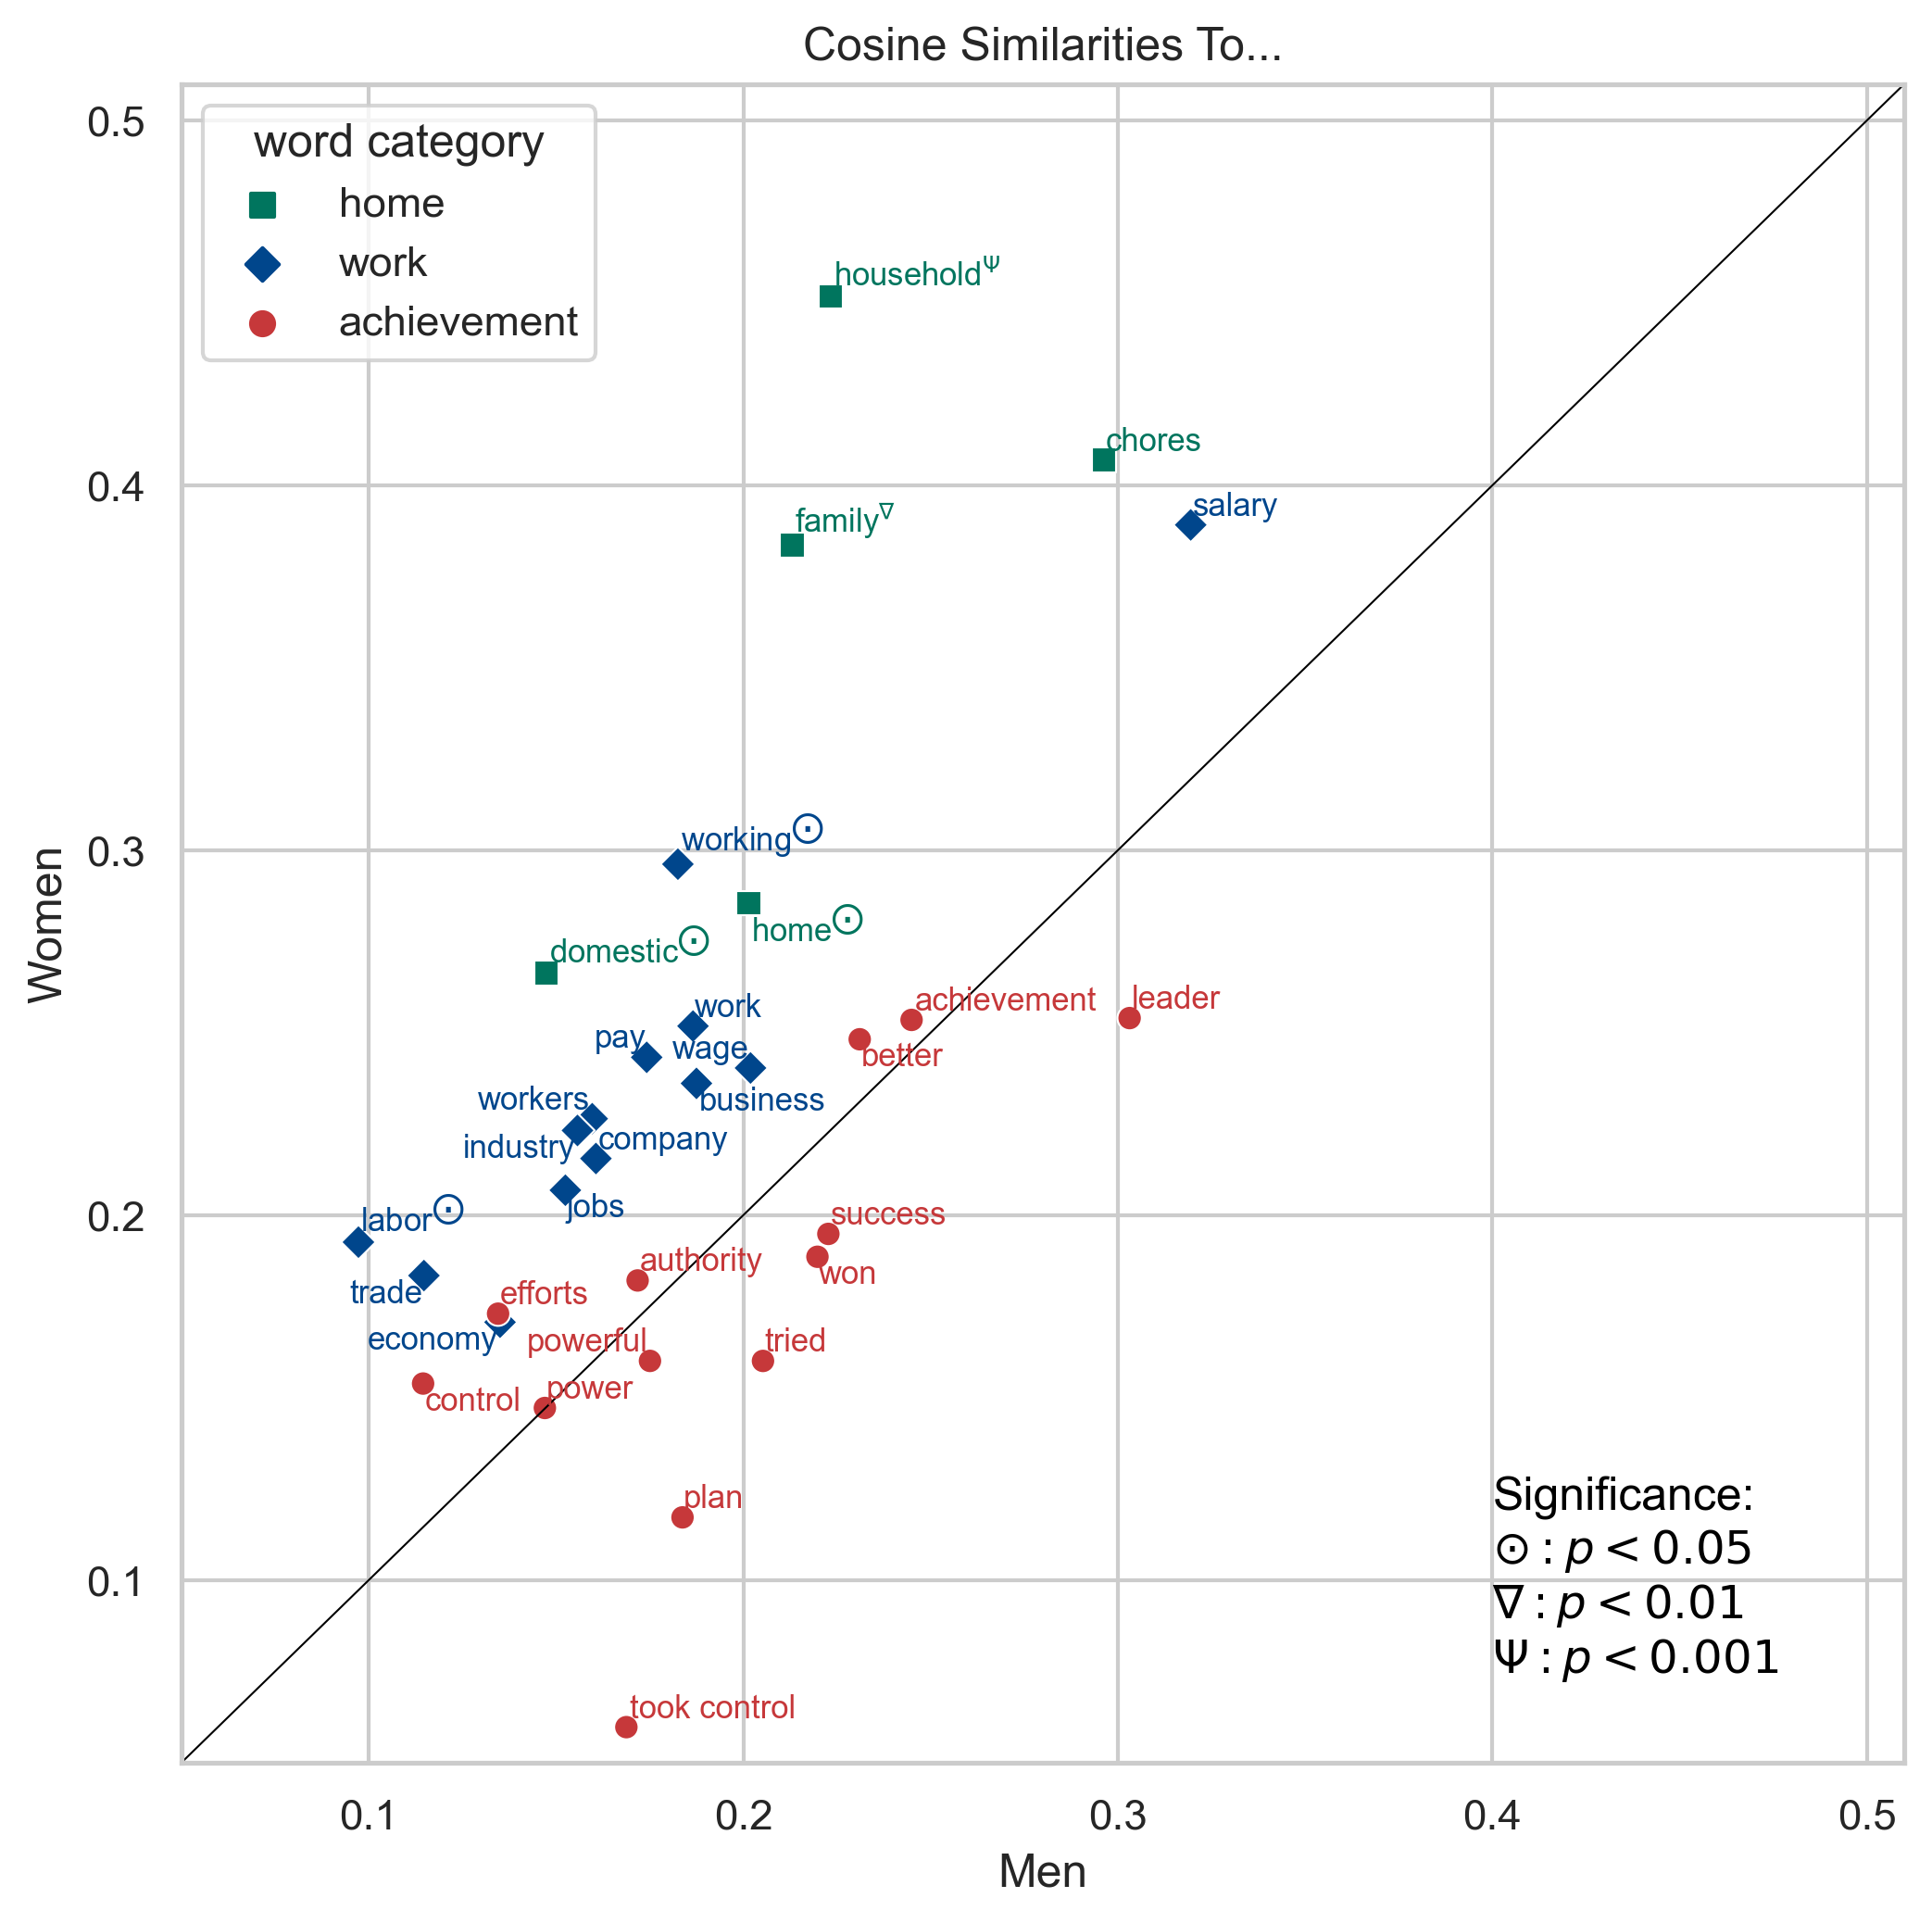

In [97]:
plot_cosines(sims)